In [1]:
import numpy as np
import math
import pandas as pd 
from datetime import date, timedelta, datetime 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import seaborn as sns

In [2]:
#Loading the data
dataset=pd.read_csv("GOOG.csv",index_col='date')
dataset.head(5)

,symbol,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
date,,,,,,,,,,,,,
2016-06-14 00:00:00+00:00,GOOG,718.27,722.47,713.1200,716.48,1306065,718.27,722.47,713.1200,716.48,1306065,0.0,1.0
2016-06-15 00:00:00+00:00,GOOG,718.92,722.98,717.3100,719.00,1214517,718.92,722.98,717.3100,719.00,1214517,0.0,1.0
2016-06-16 00:00:00+00:00,GOOG,710.36,716.65,703.2600,714.91,1982471,710.36,716.65,703.2600,714.91,1982471,0.0,1.0
2016-06-17 00:00:00+00:00,GOOG,691.72,708.82,688.4515,708.65,3402357,691.72,708.82,688.4515,708.65,3402357,0.0,1.0
2016-06-20 00:00:00+00:00,GOOG,693.71,702.48,693.4100,698.77,2082538,693.71,702.48,693.4100,698.77,2082538,0.0,1.0


In [3]:
df=dataset[['high','low','open','close','volume','adjClose']]
df.head()

,high,low,open,close,volume,adjClose
date,,,,,,
2016-06-14 00:00:00+00:00,722.47,713.1200,716.48,718.27,1306065,718.27
2016-06-15 00:00:00+00:00,722.98,717.3100,719.00,718.92,1214517,718.92
2016-06-16 00:00:00+00:00,716.65,703.2600,714.91,710.36,1982471,710.36
2016-06-17 00:00:00+00:00,708.82,688.4515,708.65,691.72,3402357,691.72
2016-06-20 00:00:00+00:00,702.48,693.4100,698.77,693.71,2082538,693.71


## Exploring the data

In [4]:
df_plot=df.copy()

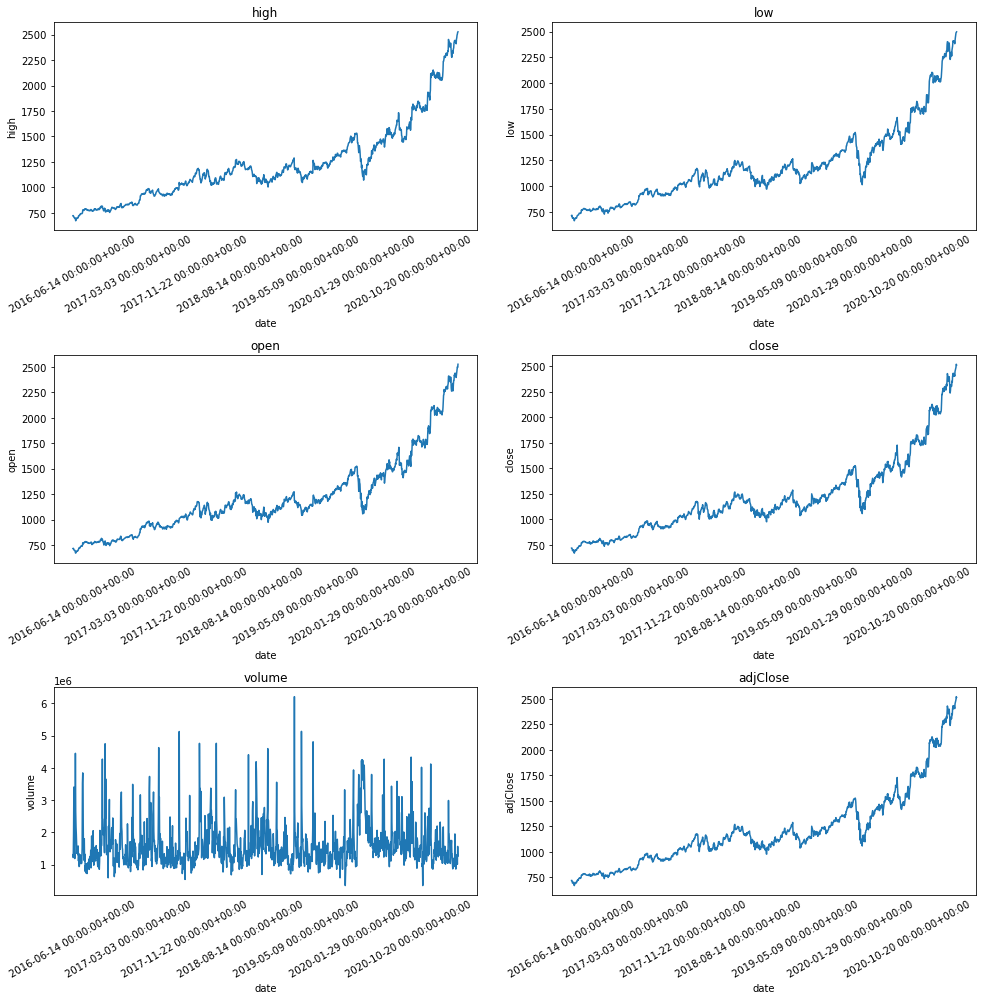

In [5]:
list_length=df_plot.shape[1]
list_length
ncols=2
nrows=int(round(list_length/ncols,0))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 14))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(0, list_length):
        ax = plt.subplot(nrows,ncols,i+1)
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.set_title(df_plot.columns[i])
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

 ## Scaling and Feature Selection

In [6]:
# Indexing Batches
train_df = df.sort_values(by=['date']).copy()

# We safe a copy of the dates index, before we need to reset it to numbers
date_index = train_df.index

# Adding Month and Year in separate columns
d = pd.to_datetime(train_df.index)
train_df['month'] = d.strftime("%m")
train_df['year'] = d.strftime("%Y") 

# We reset the index, so we can convert the date-index to a number-index
train_df = train_df.reset_index(drop=True).copy()
train_df.head(5)

,high,low,open,close,volume,adjClose,month,year
0,722.47,713.1200,716.48,718.27,1306065,718.27,06,2016
1,722.98,717.3100,719.00,718.92,1214517,718.92,06,2016
2,716.65,703.2600,714.91,710.36,1982471,710.36,06,2016
3,708.82,688.4515,708.65,691.72,3402357,691.72,06,2016
4,702.48,693.4100,698.77,693.71,2082538,693.71,06,2016


In [7]:
# List of considered Features
FEATURES = ['high', 'low', 'open', 'close', 'volume'
     ,'month'
           ]

print('FEATURE LIST')
print([f for f in FEATURES])
data_filtered = train_df[FEATURES]

data_filtered_ext=data_filtered.copy()
data_filtered_ext['prediction']=data_filtered_ext['close']
data_filtered_ext.tail(5)

FEATURE LIST
['high', 'low', 'open', 'close', 'volume', 'month']


,high,low,open,close,volume,month,prediction
1253,2468.000,2441.0725,2451.32,2466.09,1192453,06,2466.09
1254,2494.495,2468.2400,2479.90,2482.85,1253253,06,2482.85
1255,2505.000,2487.3300,2499.50,2491.40,1006337,06,2491.40
1256,2523.260,2494.0000,2494.01,2521.60,1561733,06,2521.60
1257,2526.990,2498.2900,2524.92,2513.93,1262309,06,2513.93


In [8]:
nrows=data_filtered.shape[0]
np_data_unscaled=np.array(data_filtered)
np_data_unscaled.shape
np_data=np.reshape(np_data_unscaled,(nrows,-1))

In [9]:
# Feature Scaling
scaler=MinMaxScaler()
np_data_scaled=scaler.fit_transform(np_data_unscaled)

scaler_pred=MinMaxScaler()
df_close=pd.DataFrame(data_filtered_ext['close'])
np_close_scaled=scaler_pred.fit_transform(df_close)

## Transforming the data

In [10]:
## Sliding windows algo
sequence_length=50

index_close=train_df.columns.get_loc("close")

train_data_len=math.ceil(np_data_scaled.shape[0]*0.8)

train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

def dataset_partition(sequence_length,data):
    data_X,data_y=[],[]
    data_length=data.shape[0]
    for i in range(sequence_length,data_length):
        data_X.append(data[i-sequence_length:i,:])
        data_y.append(data[i,index_close])
    X=np.array(data_X)
    y=np.array(data_y)
    return X,y

X_train,y_train=dataset_partition(sequence_length,train_data)
X_test,y_test=dataset_partition(sequence_length,test_data)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# X_train[956][4]

print(X_train[73][sequence_length-1][index_close])
print(y_train[72])

(957, 50, 6) (957,)
(251, 50, 6) (251,)
0.04901960784313725
0.04901960784313725


## Training the Multivariate Prediction Model

In [11]:
# Configuring the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = X_train.shape[1] * X_train.shape[2]
print(n_neurons, X_train.shape[1], X_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compiling the model
model.compile(optimizer='adam', loss='mse')

300 50 6


In [12]:
# Training the model
epochs = 15
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(X_test, y_test)
                   )
                    
                    #callbacks=[early_stop])

Epoch 1/15
60/60 [==============================] - 50s 731ms/step - loss: 0.0074 - val_loss: 0.0045
Epoch 2/15
60/60 [==============================] - 44s 728ms/step - loss: 3.3442e-04 - val_loss: 0.0031
Epoch 3/15
60/60 [==============================] - 45s 748ms/step - loss: 2.9423e-04 - val_loss: 0.0016
Epoch 4/15
60/60 [==============================] - 44s 733ms/step - loss: 3.2969e-04 - val_loss: 0.0032
Epoch 5/15
60/60 [==============================] - 42s 697ms/step - loss: 2.6083e-04 - val_loss: 0.0032
Epoch 6/15
60/60 [==============================] - 41s 685ms/step - loss: 2.4322e-04 - val_loss: 0.0014
Epoch 7/15
60/60 [==============================] - 41s 691ms/step - loss: 2.5299e-04 - val_loss: 0.0016
Epoch 8/15
60/60 [==============================] - 42s 702ms/step - loss: 2.5941e-04 - val_loss: 0.0038
Epoch 9/15
60/60 [==============================] - 42s 703ms/step - loss: 2.3167e-04 - val_loss: 8.6587e-04
Epoch 10/15
60/60 [==============================] - 43

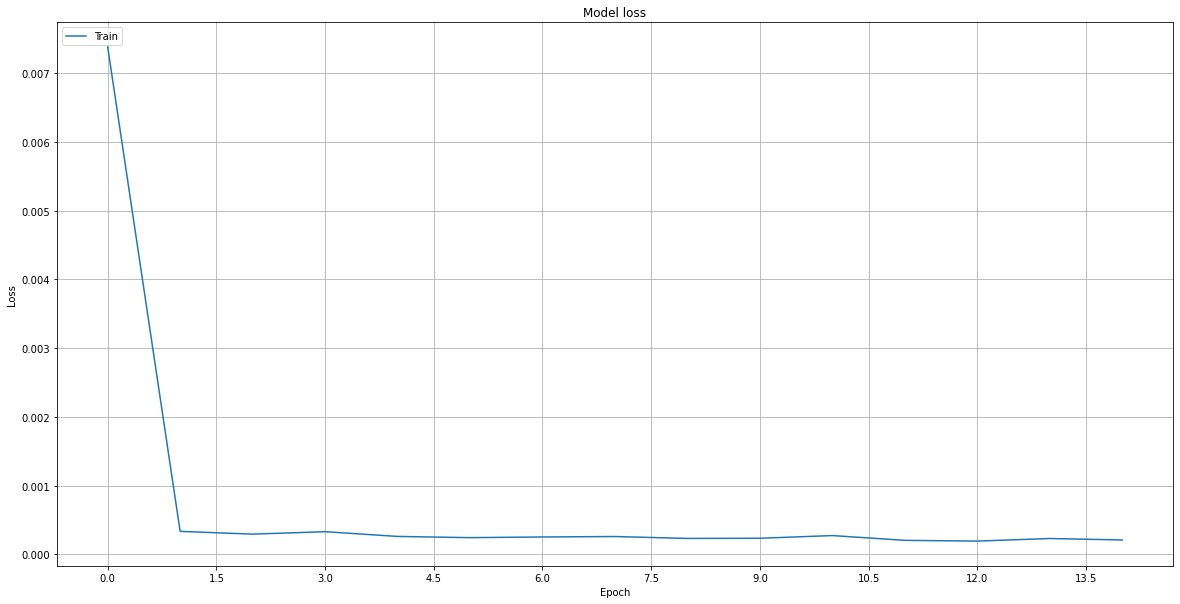

In [13]:
# Plotting training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

## Evaluating Model Performance

In [14]:
# Getting the predicted values
y_pred_scaled = model.predict(X_test)

# Unscaling the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 39.24
Mean Absolute Percentage Error (MAPE): 2.1 %
Median Absolute Percentage Error (MDAPE): 1.64 %


In [15]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp(year=2021, month=6, day=11) - timedelta(days=500)

In [16]:
# Adding the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['date'] = date_index

In [17]:
# Adding the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["prediction"] - valid["close"], True)

In [18]:
valid['date']=pd.to_datetime(valid['date']).dt.date
train['date']=pd.to_datetime(train['date']).dt.date

<ipython-input-18-9cc04f7609da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['date']=pd.to_datetime(valid['date']).dt.date
<ipython-input-18-9cc04f7609da>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['date']=pd.to_datetime(train['date']).dt.date


In [19]:
# Zooming in to a closer timeframe
valid = valid[valid['date'] > display_start_date]
train = train[train['date'] > display_start_date]

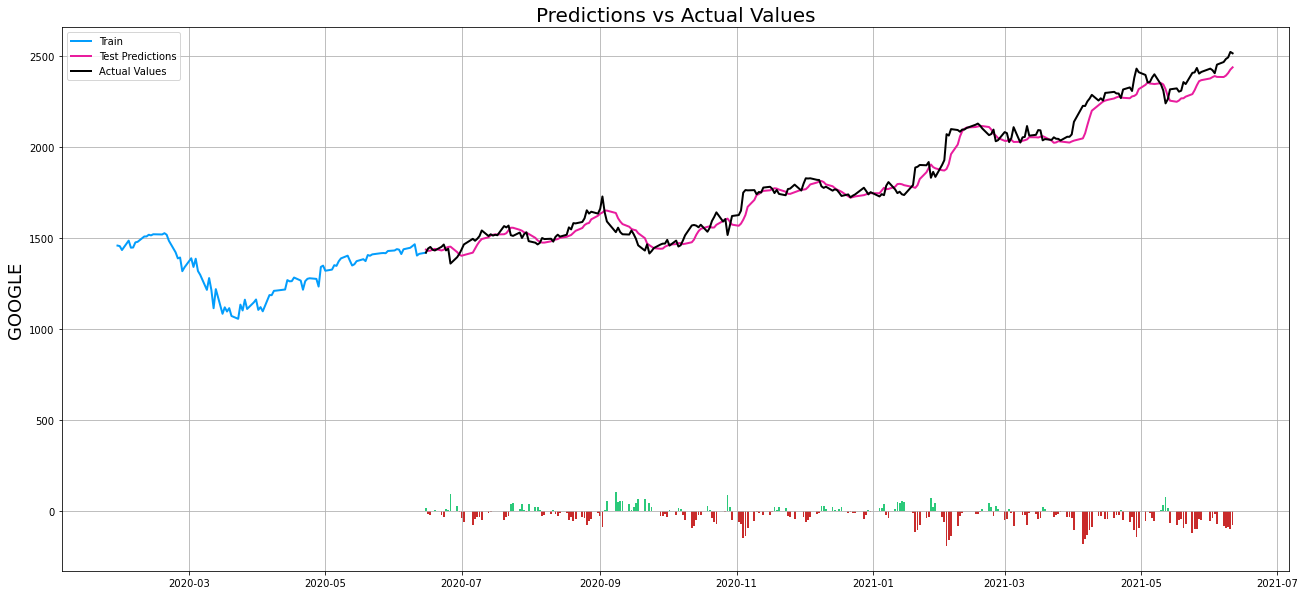

In [20]:
# Visualizing the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['date']; yt = train[["close"]]
xv = valid['date']; yv = valid[["close", "prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.ylabel("GOOGLE", fontsize=18)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Created the bar plot with the differences
x = valid['date']
y = valid["Difference"]

# Created custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()